https://medium.com/@cdabakoglu/time-series-forecasting-arima-lstm-prophet-with-python-e73a750a9887

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
warnings.filterwarnings('ignore')

In [47]:
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed

# Dataset

In [48]:
df = pd.read_csv('Asurion_data_iPhone_v3.csv', parse_dates=['weeks_monday','month_year'])
df

,phone_model,phone_generation,phone_size,phone_color,claim,weeks_monday,month,year,month_year
0,apple iphone 11,iphone 11,128gb,black,111,2021-06-28,6,2021,2021-06-01
1,apple iphone 11,iphone 11,128gb,black,319,2021-07-05,7,2021,2021-07-01
2,apple iphone 11,iphone 11,128gb,black,320,2021-07-12,7,2021,2021-07-01
3,apple iphone 11,iphone 11,128gb,black,305,2021-07-19,7,2021,2021-07-01
4,apple iphone 11,iphone 11,128gb,black,269,2021-07-26,7,2021,2021-07-01
...,...,...,...,...,...,...,...,...,...
17874,apple iphone xs max,iphone x,64gb,silver,18,2023-01-16,1,2023,2023-01-01
17875,apple iphone xs max,iphone x,64gb,silver,19,2023-01-23,1,2023,2023-01-01
17876,apple iphone xs max,iphone x,64gb,silver,14,2023-01-30,1,2023,2023-01-01
17877,apple iphone xs max,iphone x,64gb,silver,13,2023-02-06,2,2023,2023-02-01


# LSTM KERAS

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# LSTM TRAINED ON 12, Validate 13, and Predict 14

Let's retrain on iphone 13 and test on iphone 14

## Train

In [51]:
from sklearn.preprocessing import StandardScaler

In [52]:
release_dates = {
    'iphone x': '2017-11-03',
    'iphone 11': '2019-09-20',
    'iphone 12': '2020-10-23',
    'iphone 13': '2021-10-24',
    'iphone 14': '2022-09-16'
}



In [53]:
from pandas.tseries.offsets import DateOffset
#get dates from release as a feature

#Validate with one shot and rehape
train = df[df['phone_generation'] == 'iphone 13']

train['days_since_release_date'] = train.apply(lambda x: (x['weeks_monday'] - pd.to_datetime(release_dates[x['phone_generation']])).days, axis=1)



#Add one hot encoding
t_color_one_hot = pd.get_dummies(train['phone_color'])
t_model_one_hot = pd.get_dummies(train['phone_model'])

#added the one hot encoding in the dataframe
train = pd.concat([train,t_color_one_hot, t_model_one_hot ], axis = 1)



#change storage to int and convert weeks_monday to week_of_year
train['phone_size'] = train['phone_size'].str.replace('gb', '').astype(int)
train['weeks_monday'] = pd.to_datetime(train['weeks_monday'])
train['week_of_year'] = train['weeks_monday'].apply(lambda x: x.isocalendar()[1]).astype(int)

#add average claims
train['avg_claim_this_month'] = train.groupby(['year', 'month'])['claim'].transform('mean')

#get previous month
train = train.copy(deep=True)
train['prev_month_year'] = train['month_year'] - DateOffset(months=1)
train
prev_month_avg_claim = train.groupby('prev_month_year')['claim'].mean().shift(1)
prev_month_avg_claim
train = train.merge(prev_month_avg_claim.rename('avg_claim_last_month'), 
                     left_on='prev_month_year', right_index=True, how='left')


# #get previos weeks amount 
train = train.copy(deep=True)
train['1_week_ago'] = train['claim'].shift(1)
train['2_week_ago'] = train['1_week_ago'].shift(1)
train['3_week_ago'] = train['2_week_ago'].shift(1)
train['4_week_ago'] = train['3_week_ago'].shift(1)
train = train.rename(columns={'claim': 'this_week'})

#drop not needed columns
train = train.drop(['phone_model', 'phone_generation', 'phone_color', 'weeks_monday',  'week_of_year', 'month', 'year', 'month_year'], axis=1)
train = train.reset_index(drop=True)

#drop na rows
train.drop('prev_month_year', axis=1, inplace=True)
train = train.dropna()


train = train.sort_values(by='days_since_release_date', ascending=True)

train

,phone_size,this_week,days_since_release_date,blue,gold,graphite,green,midnight,pink,red,...,apple iphone 13,apple iphone 13 mini,apple iphone 13 pro,apple iphone 13 pro max,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago
88,128,2,43,0,0,0,0,1,0,0,...,1,0,0,0,4.714286,2.750000,4.0,3.0,2.0,16.0
89,128,8,50,0,0,0,0,1,0,0,...,1,0,0,0,4.714286,2.750000,2.0,4.0,3.0,2.0
90,128,5,57,0,0,0,0,1,0,0,...,1,0,0,0,4.714286,2.750000,8.0,2.0,4.0,3.0
91,128,6,64,0,0,0,0,1,0,0,...,1,0,0,0,4.714286,2.750000,5.0,8.0,2.0,4.0
4,128,3,71,1,0,0,0,0,0,0,...,1,0,0,0,8.250000,4.714286,9.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341,256,83,477,1,0,0,0,0,0,0,...,0,0,0,1,65.602564,107.101695,413.0,307.0,353.0,315.0
1491,256,12,477,0,0,0,1,0,0,0,...,0,0,0,1,65.602564,107.101695,81.0,89.0,78.0,88.0
398,256,20,477,0,0,0,0,1,0,0,...,1,0,0,0,65.602564,107.101695,71.0,70.0,64.0,87.0
1394,256,34,477,0,1,0,0,0,0,0,...,0,0,0,1,65.602564,107.101695,168.0,180.0,164.0,164.0


In [54]:
#Identify the X and Y
x_train = np.array(train.drop(['this_week'], axis=1))
y_train = np.array(train['this_week'])

# Standardize the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

#identify the number of features using our x 
n_features = x_train.shape[1]

# identify the number of samples in our training set
n_sample_validate = x_train.shape[0]

#reshape training
X_train_reshaped = x_train.reshape((n_sample_validate, 1, n_features))
y_train_reshaped = y_train.reshape((n_sample_validate, 1))

In [55]:
#input and output sequences
input_sequence_len = x_train.shape[0]
out_sequence_len = y_train.shape[0]

#input and output feature dimmension
input_feature_dim = x_train.shape[1]
output_feature_dim = y_train.shape[0]

## Test

In [56]:
# black	blue	gold	gray	green	purple	red	silver	white
# blue	gold	graphite	green	midnight	pink	red	silver	starlight
# black	blue	gold	purple	red	silver	white, green, gray

In [57]:
#test with one shot and reshape 
test = df[df['phone_generation'] == 'iphone 14']


#Validate with one shot and rehape
t_color_one_hot = pd.get_dummies(test['phone_color'])
t_model_one_hot = pd.get_dummies(test['phone_model'])

test['days_since_release_date'] = test.apply(lambda x: (x['weeks_monday'] - pd.to_datetime(release_dates[x['phone_generation']])).days, axis=1)


#added the one hot encoding in the dataframe
test = pd.concat([test,t_color_one_hot, t_model_one_hot ], axis = 1)


#change storage to int and convert weeks_monday to week_of_year
test['phone_size'] = test['phone_size'].str.replace('gb', '').astype(int)
test['weeks_monday'] = pd.to_datetime(test['weeks_monday'])
test['week_of_year'] = test['weeks_monday'].apply(lambda x: x.isocalendar()[1]).astype(int)

#add average claims
test['avg_claim_this_month'] = test.groupby(['year', 'month'])['claim'].transform('mean')

#get previous month
test = test.copy(deep=True)
test['prev_month_year'] = test['month_year'] - DateOffset(months=1)

prev_month_avg_claim = test.groupby('prev_month_year')['claim'].mean().shift(1)

test = test.merge(prev_month_avg_claim.rename('avg_claim_last_month'), 
                     left_on='prev_month_year', right_index=True, how='left')


# #get previos weeks amount 
test = test.copy(deep=True)
test['1_week_ago'] = test['claim'].shift(1)
test['2_week_ago'] = test['1_week_ago'].shift(1)
test['3_week_ago'] = test['2_week_ago'].shift(1)
test['4_week_ago'] = test['3_week_ago'].shift(1)
test = test.rename(columns={'claim': 'this_week'})



#Add in features
test['green'] = np.zeros(len(test.index))
test['gray'] = np.zeros(len(test.index))
test['apple iphone 14 plus'] = np.zeros(len(test.index))
test['apple iphone 14 pro'] = np.zeros(len(test.index))

#drop not needed columns
test = test.drop(['phone_model', 'phone_generation', 'phone_color', 'weeks_monday',  'week_of_year', 'month', 'year', 'month_year'], axis=1)
test = test.reset_index(drop=True)

#drop na rows
test.drop('prev_month_year', axis=1, inplace=True)
test = test.dropna()


test = test.sort_values(by='days_since_release_date', ascending=True)

test

,phone_size,this_week,days_since_release_date,black,blue,gold,purple,red,silver,white,...,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,green,gray,apple iphone 14 plus,apple iphone 14 pro
30,256,7,80,1,0,0,0,0,0,0,...,8.611111,6.888889,4.0,8.0,4.0,12.0,0.0,0.0,0.0,0.0
47,256,3,80,0,0,0,0,0,0,1,...,8.611111,6.888889,3.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0
17,128,8,80,0,0,0,0,0,0,1,...,8.611111,6.888889,4.0,8.0,2.0,6.0,0.0,0.0,0.0,0.0
4,128,20,87,1,0,0,0,0,0,0,...,8.611111,6.888889,25.0,15.0,11.0,7.0,0.0,0.0,0.0,0.0
31,256,6,87,1,0,0,0,0,0,0,...,8.611111,6.888889,7.0,4.0,8.0,4.0,0.0,0.0,0.0,0.0
48,256,2,87,0,0,0,0,0,0,1,...,8.611111,6.888889,3.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0
18,128,4,87,0,0,0,0,0,0,1,...,8.611111,6.888889,8.0,4.0,8.0,2.0,0.0,0.0,0.0,0.0
5,128,20,94,1,0,0,0,0,0,0,...,8.611111,6.888889,20.0,25.0,15.0,11.0,0.0,0.0,0.0,0.0
40,256,2,94,0,1,0,0,0,0,0,...,8.611111,6.888889,11.0,10.0,9.0,12.0,0.0,0.0,0.0,0.0
32,256,4,94,1,0,0,0,0,0,0,...,8.611111,6.888889,6.0,7.0,4.0,8.0,0.0,0.0,0.0,0.0


In [58]:
#Identify the X and Y
x_test = np.array(test.drop(['this_week'], axis=1))
y_test = np.array(test['this_week'])

# Standardize the features
scaler = StandardScaler()
x_test = scaler.fit_transform(x_test)

#identify the number of features using our x 
n_features = x_test.shape[1]

# identify the number of samples in our training set
n_sample_test = x_test.shape[0]

#reshape training
X_test_reshaped = x_test.reshape((n_sample_test, 1, n_features))
y_test_reshaped = y_test.reshape((n_sample_test, 1))

# Model

**Optimizers:** Classes or methods used to change the attributes of your machine/deep learning model such as weights and learning rate in order to reduce the losses. Optimizers help to get results faster


source: https://analyticsindiamag.com/guide-to-tensorflow-keras-optimizers/#:~:text=Optimizers%20are%20Classes%20or%20methods,help%20to%20get%20results%20faster.

In [59]:
from tensorflow.keras import layers
# define optimzer
optimizer = keras.optimizers.Adam(lr = 0.01)

### Defining the model and its layer

Timedistributed layer wraps every layer and applies it at every time step. It reshapes the inputs from batch size, input, dimmension and treat it as a separate instance.reshapes the inputs from 

**[batch size, time steps, input dimensions]** to **[batch size × time steps, input dimensions]**

In [60]:
#LSTM unit and dropout dimmention
lstm_unit = 24
lstm_layer = 3
lstm_dropout = 0.2

#Model
model = Sequential()
model.add(LSTM(units=lstm_unit, activation = 'relu', input_shape = (1, input_feature_dim), 
               return_sequences=True))
model.add(LSTM(units=lstm_unit, 
               return_sequences=True))
model.add(Dense(units =1))

In [61]:
# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

***Mean Absolute Percentage Error (MAPE)***

The Mean Absolute Percentage Error (MAPE) is a common metric for measuring error in forecasts. The MAPE represents error as a percentage of the actual observed values. A high MAPE value means the error is large relative to the quantity being measuring and so the forecast is poor. A small MAPE means the error is relatively small so the forecast is good.

The MAPE is given by:

$$ MAPE = \frac{1}{n} \sum_{i=1}^{n} \frac{|F_t - A_t|}{A_t} $$

where $A_t$ is the actual observed value, $F_t$ is the forecast, and $n$ is the number of data points the MAPE is being calculated over. Read about MAPE at https://en.wikipedia.org/wiki/Mean_absolute_percentage_error


**The function returns the MAPE as decimal rounded to 5 decimal places (i.e. MAPE = 0.10325)**


In [ ]:
def get_mape(actuals, forecasts):
    MAPE = np.sum(np.abs(forecasts - actuals)/actuals)/len(forecasts)
    return MAPE
    

####wmape

In [62]:
def wmape(actual, forecast):
    # we take two series and calculate an output a wmape from it, not to be used in a grouping function
    # make a series called mape
    se_mape = abs(actual-forecast)/actual
    # get a float of the sum of the actual
    ft_actual_sum = actual.sum()
    # get a series of the multiple of the actual & the mape
    se_actual_prod_mape = actual * se_mape
    # summate the prod of the actual and the mape
    ft_actual_prod_mape_sum = se_actual_prod_mape.sum()
    # float: wmape of forecast
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum
    # return a float
    return ft_wmape_forecast

In [63]:

history = model.fit(X_train_reshaped, y_train_reshaped, epochs=60, batch_size=32)

Epoch 1/60
52/52 [==============================] - 4s 5ms/step - loss: 10403.7480
Epoch 2/60
52/52 [==============================] - 0s 5ms/step - loss: 8901.6533
Epoch 3/60
52/52 [==============================] - 0s 4ms/step - loss: 7961.4482
Epoch 4/60
52/52 [==============================] - 0s 4ms/step - loss: 7149.4292
Epoch 5/60
52/52 [==============================] - 0s 5ms/step - loss: 6466.3901
Epoch 6/60
52/52 [==============================] - 0s 5ms/step - loss: 5890.2734
Epoch 7/60
52/52 [==============================] - 0s 4ms/step - loss: 5399.3149
Epoch 8/60
52/52 [==============================] - 0s 4ms/step - loss: 4986.9624
Epoch 9/60
52/52 [==============================] - 0s 4ms/step - loss: 4628.1377
Epoch 10/60
52/52 [==============================] - 0s 4ms/step - loss: 4315.7852
Epoch 11/60
52/52 [==============================] - 0s 4ms/step - loss: 4030.9590
Epoch 12/60
52/52 [==============================] - 0s 4ms/step - loss: 3780.5432
Epoch 13/60


#### Validate Prediction on 13

In [64]:
def wmape(actual, forecast):
    # we take two series and calculate an output a wmape from it, not to be used in a grouping function
    # make a series called mape
    se_mape = abs(actual-forecast)/actual
    # get a float of the sum of the actual
    ft_actual_sum = actual.sum()
    # get a series of the multiple of the actual & the mape
    se_actual_prod_mape = actual * se_mape
    # summate the prod of the actual and the mape
    ft_actual_prod_mape_sum = se_actual_prod_mape.sum()
    # float: wmape of forecast
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum
    # return a float
    return ft_wmape_forecast

In [ ]:
predict = model.predict(X_validate_reshaped)


52/52 [==============================] - 0s 790us/step


In [ ]:
#get array of outputs from predicted set
validate_result = [i[0][0] for i in predict]

predicted_MAPE= wmape(y_validate,validate_result )
predicted_MAPE

0.6822629215990598

In [ ]:
validate['predicted'] = validate_result
validate

,phone_size,claim,month,year,blue,gold,graphite,green,midnight,pink,red,silver,starlight,apple iphone 13,apple iphone 13 mini,apple iphone 13 pro,apple iphone 13 pro max,week_of_year,predicted
6246,128,2,11,2021,1,0,0,0,0,0,0,0,0,1,0,0,0,48,29.586292
6247,128,2,12,2021,1,0,0,0,0,0,0,0,0,1,0,0,0,50,34.302467
6248,128,1,12,2021,1,0,0,0,0,0,0,0,0,1,0,0,0,51,34.970882
6249,128,9,12,2021,1,0,0,0,0,0,0,0,0,1,0,0,0,52,35.625622
6250,128,3,1,2022,1,0,0,0,0,0,0,0,0,1,0,0,0,1,19.833988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7902,512,1,1,2023,0,0,0,0,0,0,0,1,0,0,0,0,1,3,5.469771
7903,512,2,1,2023,0,0,0,0,0,0,0,1,0,0,0,0,1,4,5.469198
7904,512,8,1,2023,0,0,0,0,0,0,0,1,0,0,0,0,1,5,5.468489
7905,512,14,2,2023,0,0,0,0,0,0,0,1,0,0,0,0,1,6,5.459753


#### Validate Prediction on 14

In [65]:
predict = model.predict(X_test_reshaped)

2/2 [==============================] - 1s 7ms/step


In [66]:
#get array of outputs from predicted set
test_result = [i[0][0] for i in predict]

predicted_MAPE= wmape(y_test,test_result )
predicted_MAPE

4.765468233161503

In [69]:
iphone_14_predicted = test[['days_since_release_date', 'this_week', 'predicted']].groupby('days_since_release_date').sum()
iphone_14_predicted

,this_week,predicted
days_since_release_date,,
80,18,116.718445
87,32,243.045624
94,36,332.508545
101,44,352.019928
108,45,299.008911
115,59,407.491913
122,60,340.178802
129,57,353.765198
136,54,427.144135


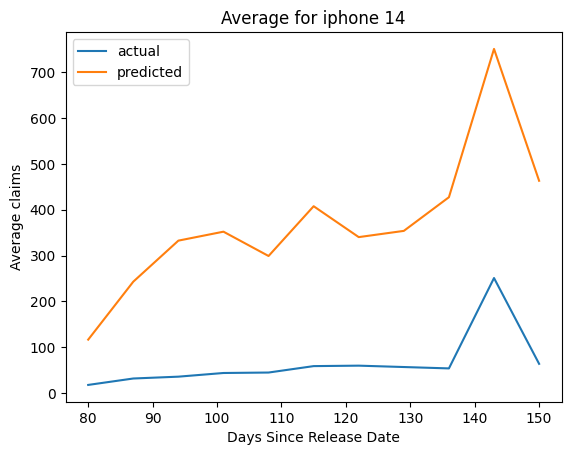

In [71]:
plt.plot(iphone_14_predicted.index, iphone_14_predicted['this_week'], label='actual')
plt.plot(iphone_14_predicted.index, iphone_14_predicted['predicted'], label='predicted')

plt.xlabel('Days Since Release Date')
plt.ylabel('Average claims')
plt.title('Average for iphone 14')
plt.legend()
plt.show()